In [14]:
import numpy as np
import pandas as pd
import scipy 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

Halflife of Anti-Epileptic Drugs

In [15]:
halflife = pd.DataFrame({
    'lacosamide':[13],
    'levetiracetam':[6],
    'midazolam':[1.5],
    'pentobarbital':[15],
    'phenobarbital':[53],
    'phenytoin':[22],
    'propofol':[1.5],
    'valproate':[8]
    },index=['t1/2'])

halflife = halflife.append(np.log(2) / halflife.rename(index={'t1/2':'k'}))

In [16]:
halflife.head()
print(halflife.shape)
halflife.columns

(2, 8)


Index(['lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital',
       'phenobarbital', 'phenytoin', 'propofol', 'valproate'],
      dtype='object')

## PK PD Model

PK: Calculating Drug Concentration in the body

In [17]:
def drug_concentration(d_ts,k):
    k_ts = np.array([ np.exp(-k*t) for t in range(d_ts.shape[1]) ]).T
    conc = np.array([np.convolve(d_ts[i],k_ts[i],'full') for i in range(d_ts.shape[0])])
    return conc

PD: E’(t) = sigmoid( g(C) + n(t) + b1 + c2*nonlinearfunction(E(t-1)) ) x ( 1 - sigmoid( h(x(t)) + f(C) +b2 ) )

In [18]:
def pharmacodynamics(args,d_conc,E0,T):
#     np.random.seed(0)
    a0 = args[0]
    a = args[1:1+E0.shape[0]]
    b0 = args[1+E0.shape[0]]
    b = np.abs(args[2+E0.shape[0]:2+E0.shape[0]+d_conc.shape[0]])
    e = np.abs(args[2+E0.shape[0]+d_conc.shape[0]])
#     g = args[3+E0.shape[0]+d_conc.shape[0]:3+E0.shape[0]+d_conc.shape[0]+C.shape[0]]
#     f = args[3+E0.shape[0]+d_conc.shape[0]+C.shape[0]:3+E0.shape[0]+d_conc.shape[0]+2*C.shape[0]]
    E = np.zeros((T,))
    E[:E0.shape[0]] = E0
    for t in range(E0.shape[0],T):
        A = a0 + np.dot(a,E[t-E0.shape[0]:t]) #+ 0*np.dot(g,C)
        B = b0 + np.dot(b,d_conc[:,t]) + np.abs(np.random.normal(0,e)) #+ 0*np.dot(f,C)
        E1 = scipy.special.expit(A)*(1-scipy.special.expit(B)) 
        E[t] = E1
    return np.clip(E,0,1)

# Real IIC Data

## Read Patient's Waveforms

In [19]:
import os
import scipy.io as io

def patient(file):
    window=900
    step=900
    df_temp = pd.DataFrame()
    if '.mat' in file:
        s = io.loadmat(file)
        human_iic_dummy = pd.get_dummies(s['human_iic'][0],dummy_na=False).rename(columns=lambda x: str(x) )
        human_iic_dummy_1hour = pd.DataFrame([np.mean(human_iic_dummy.loc[i:i+window,:],axis=0) for i in range(0,human_iic_dummy.shape[0],step)])
        
        drugs = s['drugs_weightnormalized']
        drugnames = list(map(lambda x: x.replace(' ',''),s['Dnames']))
        drugs_1hr = pd.DataFrame([ np.mean(drugs[i:i+window,:],axis=0) for i in range(0,human_iic_dummy.shape[0],step) ],columns=drugnames)
        change_drug_1hr = drugs_1hr.diff().rename(columns=lambda x: 'd_'+x)
        drugs_1hr = drugs_1hr.join(change_drug_1hr)
        
        for i in range(human_iic_dummy_1hour.shape[0]):
            if (human_iic_dummy_1hour.loc[i,:]==0).all():
                drugs_1hr.loc[i,:] = np.nan 
                human_iic_dummy_1hour.loc[i,:] = np.nan
        
        human_iic_dummy_1hour['IIC'] = 1 - human_iic_dummy_1hour['0.0']
        if '5.0' in human_iic_dummy_1hour.columns:
            human_iic_dummy_1hour['IIC'] = human_iic_dummy_1hour['IIC'] - human_iic_dummy_1hour['5.0']
        change_iic_1hr = human_iic_dummy_1hour.diff().rename(columns=lambda x: 'd_'+x)
        human_iic_dummy_1hour = human_iic_dummy_1hour.join(change_iic_1hr)
        
        df_temp = human_iic_dummy_1hour.join(drugs_1hr)
        df_temp['sid'] = [file.split('.')[0] for i in range(df_temp.shape[0])]
    return df_temp

## Read Patient's Covariates

In [20]:
covariates = pd.read_csv('/data/Dropbox (Partners HealthCare)/CausalModeling_IIIC/data_to_share/step1_output/covariates.csv').set_index('Index').dropna(axis=1)
covariates

,Gender,Age,Hx CVA (including TIA),Hx HTN,Hx Sz /epilepsy,Hx brain surgery,Hx CKD,Hx CAD/MI,Hx CHF,Hx DM,...,iGCS-Total,iGCS = T?,iGCS-E,iGCS-V,iGCS-M,Worst GCS in 1st 24,Worst GCS Intubation status,iGCS actual scores,neuro_dx_Seizures/status epilepticus,prim_dx_Respiratory disorders
Index,,,,,,,,,,,,,,,,,,,,,
sid36,0,73.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,9,0,4,1,4,3,1,9,0,0
sid39,0,70.77,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9,0,4,1,4,9,0,9,1,0
sid56,1,82.84,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,12,0,4,3,5,3,1,12,1,0
sid297,0,58.95,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,15,0,4,5,6,15,0,15,0,0
sid327,0,45.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,1,1,1,5,7,1,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sid1101,1,65.29,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,15,0,4,5,6,14,0,15,1,0
sid1102,1,63.97,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,15,0,4,5,6,15,0,15,1,1
sid1105,1,68.28,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,15,0,4,5,6,15,0,15,0,0


## Leave One Out Loss

In [21]:
def loss_loo(args,i):
    files = os.listdir('/data/Dropbox (Partners HealthCare)/CausalModeling_IIIC/data_to_share/step1_output')
    covariates = pd.read_csv('/data/Dropbox (Partners HealthCare)/CausalModeling_IIIC/data_to_share/step1_output/covariates.csv').set_index('Index').dropna(axis=1)
    k = halflife.loc['k'].to_numpy()
    loss = 0
    for file in files:
        #Leave one out procedure
        if( ('.mat' in file) and (i not in file) ):
            np.random.seed(0)
            
            #fetch the data
            sid = file.split('.')[0]
            p = patient(file)
            
            #setting up the data
            Eobs1 = np.clip(p['IIC'].to_numpy(),0,1)
            Eobs = np.clip(p['IIC'].interpolate(method='cubic').to_numpy(),0,1)
            Dobs = p[['lacosamide', 'levetiracetam', 'midazolam', 
                            'pentobarbital','phenobarbital', 'phenytoin', 'propofol', 'valproate']].fillna(0).to_numpy().T
            T = Eobs.shape[0]
            
            #PK
            d_conc = drug_concentration(Dobs,k)[:,:T]
            
            #PD (loss)
            c = 0.001
            loss += (np.mean(np.square(np.array(pharmacodynamics(args,d_conc,Eobs[0:2],T)) - Eobs)) + c*np.linalg.norm(args))
    return loss

## Self Prediction Loss

In [22]:
def loss_self(args,sid,frac=0.5):
    covariates = pd.read_csv('/data/Dropbox (Partners HealthCare)/CausalModeling_IIIC/data_to_share/step1_output/covariates.csv').set_index('Index').dropna(axis=1)
    k = halflife.loc['k'].to_numpy()
    
    np.random.seed(0)

    #fetch the data
    file = sid + '.mat'
    p = patient(file)

    #setting up the data
    Eobs1 = np.clip(p['IIC'].to_numpy(),0,1)
    Eobs = np.clip(p['IIC'].interpolate(method='cubic').to_numpy(),0,1)
    Dobs = p[['lacosamide', 'levetiracetam', 'midazolam', 
                    'pentobarbital','phenobarbital', 'phenytoin', 'propofol', 'valproate']].fillna(0).to_numpy().T
    T = Eobs.shape[0]

    #PK
    d_conc = drug_concentration(Dobs,k)[:,:T]

    #PD (loss)
    c = 0.001
    loss = (np.mean(np.square(np.array(pharmacodynamics(args,d_conc,Eobs[0:2],int(T*frac))) - Eobs[:int(T*frac)] )) + c*np.linalg.norm(args))
    
    return loss

## Function to Plot Simulated Data

In [23]:
def plot_sim(args,sid):
    covariates = pd.read_csv('/data/Dropbox (Partners HealthCare)/CausalModeling_IIIC/data_to_share/step1_output/covariates.csv').set_index('Index').dropna(axis=1)
    k = halflife.loc['k'].to_numpy()
    
    np.random.seed(0)

    #fetch the data
    file = sid + '.mat'
    p = patient(file)

    #setting up the data
    Eobs1 = np.clip(p['IIC'].to_numpy(),0,1)
    Eobs = np.clip(p['IIC'].interpolate(method='cubic').to_numpy(),0,1)
    Dobs = p[['lacosamide', 'levetiracetam', 'midazolam', 
                    'pentobarbital','phenobarbital', 'phenytoin', 'propofol', 'valproate']].fillna(0).to_numpy().T
    T = Eobs.shape[0]

    #PK
    d_conc = drug_concentration(Dobs,k)[:,:T]

    #PD
    params = args
    params[4:4+d_conc.shape[0]] = np.abs(params[4:4+d_conc.shape[0]])
    params[-1] = np.abs(params[-1])
    E = np.array(pharmacodynamics(params,d_conc,Eobs[0:2],T))
    
    #baselines
    Erandom = np.clip(np.random.normal(np.mean(Eobs),np.std(Eobs),size=len(Eobs)),0,1)
    zero_param = np.append(np.zeros(len(params)-1,),[params[-1]])
    Enoise = np.array(pharmacodynamics(0*params,d_conc,Eobs[0:2],T))
    
    fig,ax = plt.subplots(2,1)
    plt.title(file.split('.')[0])
    ax[0].plot(E)
    ax[0].plot(Eobs1)
    # ax[0].plot(Erandom)
    # ax[0].plot(Enoise)
#     ax[0].plot(Eobs,'--',alpha=0.3,)
    # ax[0].fill_between(np.arange(T),y1=E+2*params[-1],y2=E-2*params[-1],alpha=0.15)

    ax[1].plot(d_conc.T,alpha=0.75)
    ax[0].legend(['Simulated','Observed'],bbox_to_anchor=(1.1, 1.05))
    ax[1].legend(halflife.columns,bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    fig.savefig('Figures/'+sid+'.png')

## Learning Parameters for All Patients

In [24]:
def learn_all(w=100):
    files = os.listdir('/data/Dropbox (Partners HealthCare)/CausalModeling_IIIC/data_to_share/step1_output')
    trained_sid = []
    params = []
    loss_array = []
    for file in files:
        #Leave one out procedure
        if( ('.mat' in file) ):
            #sid
            sid = file.split('.')[0]
            #learn
            args0 = np.zeros((3+Eobs[0:2].shape[0]+d_conc.shape[0],))
            loss = lambda args: loss_loo(args,sid) + w*loss_self(args,sid)
            args_ = scipy.optimize.minimize(loss,args0,method='COBYLA',options={'maxiter':50000})
            #Plot
            if args_.success:
                plot_sim(args_.x,sid)
                trained_sid.append(sid)
                params.append(args_.x)
                loss_array.append(loss(args_.x))
    return trained_sid, params, loss_array

In [25]:
trained_sid, params_learned, loss_array = learn_all(w=100)

params_learned = np.array(params_learned)
loss_array_2 = np.max(loss_array) - np.array(loss_array)
# print(params_learned.mean(axis=0))
# print(params_learned.std(axis=0))

df_param = pd.DataFrame(params_learned,index=trained_sid,columns=['a0']+['a.%d'%(i) for i in range(1,3)]+['b0']+['b.%s'%(halflife.columns[i]) for i in range(halflife.shape[1])]+['std.noise'])
df_param['loss'] = loss_array

fig = plt.figure()
sns.scatterplot(x='b.propofol',y='b.midazolam',hue='loss',data=df_param,palette='RdBu')
plt.legend(bbox_to_anchor=(1.2, 1.05))
fig = plt.figure()
sns.scatterplot(x='b.propofol',y='b.levetiracetam',hue='loss',data=df_param,palette='RdBu')
plt.legend(bbox_to_anchor=(1.2, 1.05))
fig = plt.figure()
sns.scatterplot(x='b.propofol',y='b0',hue='loss',data=df_param,palette='RdBu')
plt.legend(bbox_to_anchor=(1.2, 1.05))
fig = plt.figure()
sns.scatterplot(x='a0',y='b0',hue='loss',data=df_param,palette='RdBu')
plt.legend(bbox_to_anchor=(1.2, 1.05))
fig = plt.figure()
sns.scatterplot(x='a.1',y='a.2',hue='loss',data=df_param,palette='RdBu')
plt.legend(bbox_to_anchor=(1.2, 1.05))
df_param_w = pd.DataFrame((loss_array_2.reshape(-1,1)*params_learned*len(loss_array_2)/np.sum(loss_array_2)),columns=['a0']+['a.%d'%(i) for i in range(1,3)]+['b0']+['b.%s'%(halflife.columns[i]) for i in range(halflife.shape[1])]+['std.noise'])
covariance_params = df_param_w.corr()
# np.fill_diagonal(covariance_params.to_numpy(),np.nan)
fig = plt.figure()
sns.heatmap(covariance_params,cmap='RdBu',center=0.0)

fig = plt.figure()
sns.jointplot(x='a0',y='b0',data=df_param,kind='kde')
sns.jointplot(x='b.propofol',y='b.midazolam',data=df_param,kind='kde')
sns.jointplot(x='b.propofol',y='b.levetiracetam',data=df_param,kind='kde')
sns.jointplot(x='b.propofol',y='b0',data=df_param,kind='kde')
sns.jointplot(x='a.1',y='a.2',data=df_param,kind='kde')


NameError: name 'Eobs' is not defined

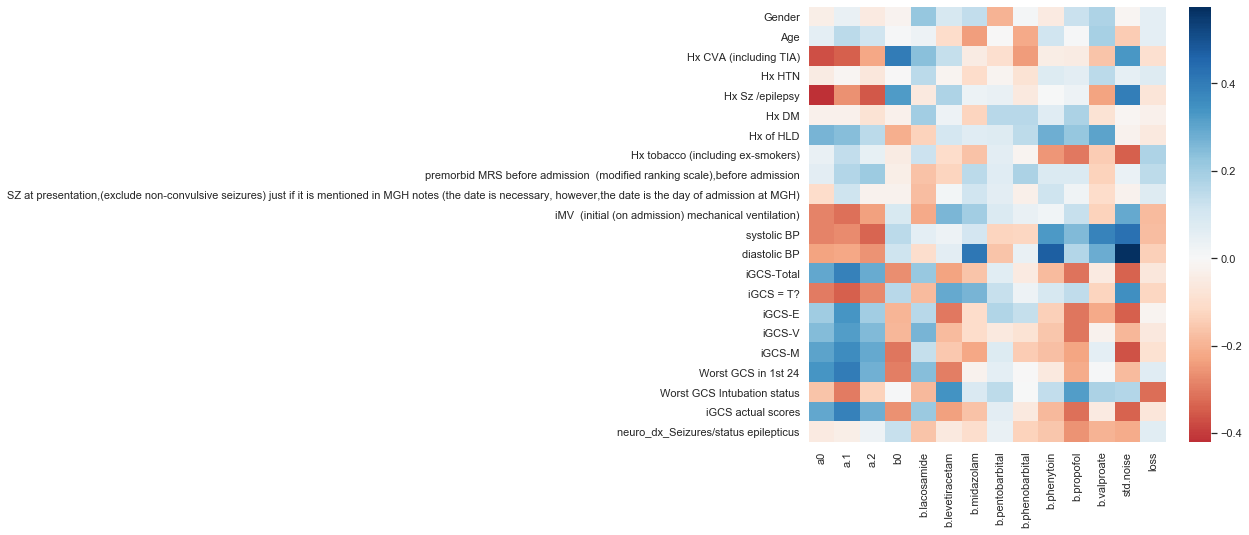

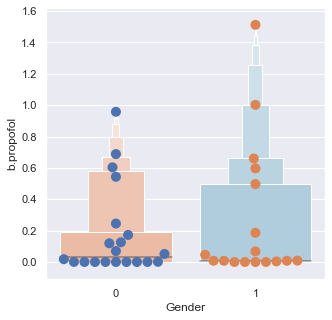

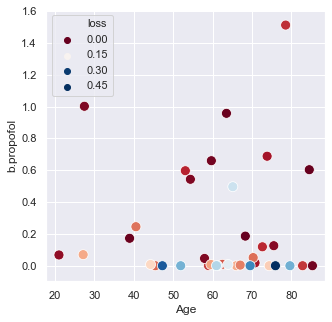

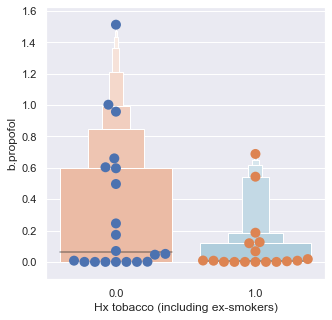

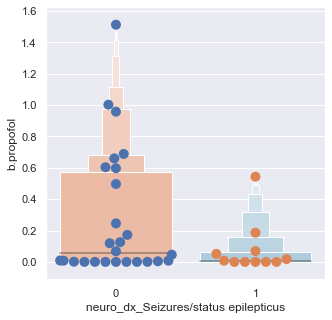

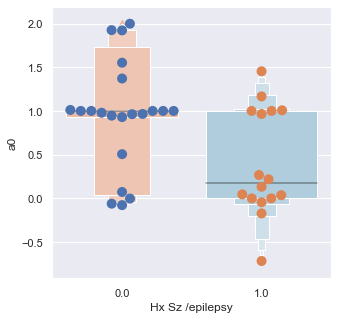

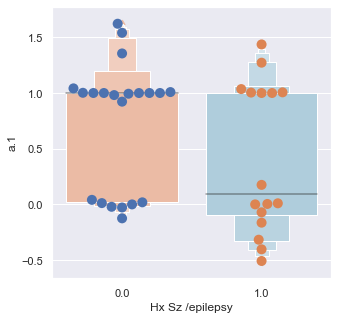

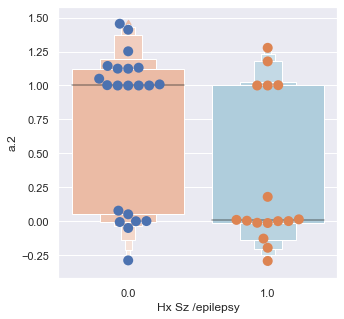

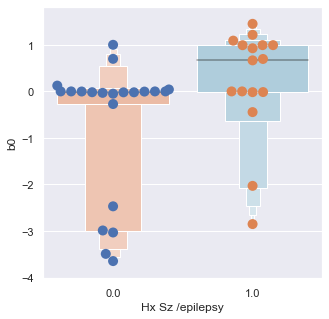

In [25]:
df_join = covariates.join(df_param,how='left')
corr_cov = df_join.corr().iloc[:22,22:]
fig = plt.figure(figsize=(8,8))
sns.heatmap(corr_cov,cmap='RdBu',center=0.0)

fig = plt.figure(figsize=(5,5))
sns.boxenplot(x='Gender',y='b.propofol',data=df_join,palette='RdBu')
sns.swarmplot(x='Gender',y='b.propofol',data=df_join,s=10)

fig = plt.figure(figsize=(5,5))
sns.scatterplot(x='Age',y='b.propofol',hue='loss',data=df_join,palette='RdBu',s=100)

fig = plt.figure(figsize=(5,5))
sns.boxenplot(x='Hx tobacco (including ex-smokers)',y='b.propofol',data=df_join,palette='RdBu')
sns.swarmplot(x='Hx tobacco (including ex-smokers)',y='b.propofol',data=df_join,s=10)

# fig = plt.figure(figsize=(5,5))
# sns.boxenplot(x='Worst GCS in 1st 24',y='b.levetiracetam',data=df_join,palette='RdBu')
# sns.swarmplot(x='Worst GCS in 1st 24',y='b.levetiracetam',data=df_join,s=10)

fig = plt.figure(figsize=(5,5))
sns.boxenplot(x='neuro_dx_Seizures/status epilepticus',y='b.propofol',data=df_join,palette='RdBu')
sns.swarmplot(x='neuro_dx_Seizures/status epilepticus',y='b.propofol',data=df_join,s=10)

# fig = plt.figure(figsize=(5,5))
# sns.regplot(x='iGCS actual scores',y='b.propofol',data=df_join)
# sns.swarmplot(x='iGCS actual scores',y='b.propofol',data=df_join,s=10)

fig = plt.figure(figsize=(5,5))
sns.boxenplot(x='Hx Sz /epilepsy',y='a0',data=df_join,palette='RdBu')
sns.swarmplot(x='Hx Sz /epilepsy',y='a0',data=df_join,s=10)

fig = plt.figure(figsize=(5,5))
sns.boxenplot(x='Hx Sz /epilepsy',y='a.1',data=df_join,palette='RdBu')
sns.swarmplot(x='Hx Sz /epilepsy',y='a.1',data=df_join,s=10)

fig = plt.figure(figsize=(5,5))
sns.boxenplot(x='Hx Sz /epilepsy',y='a.2',data=df_join,palette='RdBu')
sns.swarmplot(x='Hx Sz /epilepsy',y='a.2',data=df_join,s=10)

fig = plt.figure(figsize=(5,5))
sns.boxenplot(x='Hx Sz /epilepsy',y='b0',data=df_join,palette='RdBu')
sns.swarmplot(x='Hx Sz /epilepsy',y='b0',data=df_join,s=10)

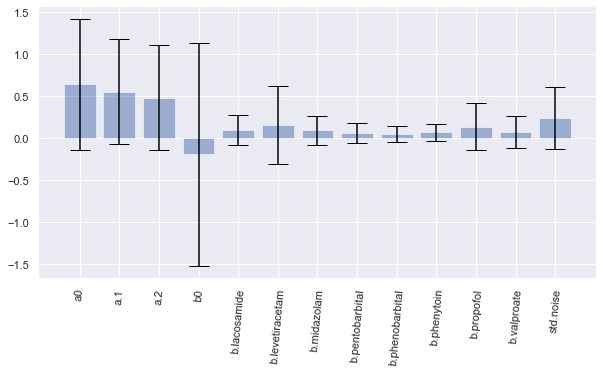

In [26]:
est_params = (params_learned).mean(axis=0)
x_pos = np.arange(params_learned.shape[1])
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x_pos, est_params, yerr=params_learned.std(axis=0), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(['a0']+['a.%d'%(i) for i in range(1,3)]+['b0']+['b.%s'%(halflife.columns[i]) for i in range(d_conc.shape[0])]+['std.noise'],rotation=85)
                   #+['g.%s'%(covariates.columns[i]) for i in range(cov.shape[0])]+['f.%s'%(covariates.columns[i]) for i in range(cov.shape[0])],rotation=85)
fig.savefig('estimates_params_pkpd.png')